# Lingaro - Data Science

Plik ten zawiera przykładowy kod w języku Python prezentujący wywołanie metod składania modeli.

## Składanie klasyfikatrów - model ensemble
Składanie klasyfikatorów jest powszechnie stosowanym podejściem uczenia maszynowego. Założeniem jest wykorzystanie wielu algorytmów uczenia w celu poprawienia ich możliwości uogólnienia/odporności w stosunku do pojednyczego modelu.

Są 3 podstawowe rodzaje składania modeli:
1. **Bagging** (Bootstrap Aggregation) - metoda ta polega na podziale zbioru treningowego na podzbiory danych treningowych losowane ze zwracaniem (próby bootstrapowe). Dla każdego podzbioru buduje się klasyfikator. Następnie wyniki klasyfikacji dla danej próbki łączone są przy pomocy średniej lub większości głosowań. Bagging pozwala na zmiejszenie błędu wariancji.
2. **Boosting** - polega na sekwencyjnym uczeniu klasyfikatorów. Pierwszy klasyfikator uczony jest na całym zbiorze danych treningowych, a następny zbiór treningowy jest zbiorem wyników otrzymanych z poprzedniego klasyfikatora. Boosting posiada lepszą zdolność prognozowania od Baggingu ale posiada tendencję do nadmiernego dopasowania danych treningowych. Dwa najbardziej znane algoytmy to AdaBoost i Gradient Boost.
3. **Kombinacja modeli: Voting i Stacking** - polega na pracy w dwóch fazach. W pierwszej fazie wykorzystujemy wiele klasyfikatorów do przewidywania klasy. Następnie w przypadku *Votingu* dokonuje się głosowania nad klasą wynikową poprzez wybranie najczęściej występującej klasy *hard voting* lub przy użyciu prawdopodobieństwa wyniku, czy też poprzez zwiększenie pewność danego modelu *soft voting*. W przypadku *stackingu* wykorzystuje się kolejny klasyfikator do łączenia poszczególnych modeli w celu zmniejszenia błędu generalizacji. 

W przypadku łączenia modeli możemy wykorzystać kombinację tych samych algorytmów uczenia maszynowego ale łączenie rezultaów generowanych przez różne algorytmy daje lepsze przewidywania. Na przykad połączenie lasów losowych (połącznie drzew decyzyjnych), KNN-a i naiwnego Bayesa działa lepiej niż połączenie ze sobą trzech modeli lasów losowych. Kluczem do stworzenia potężnego zestawu modeli jest ich różnorodność. 

### 1 Generowanie zbioru danych

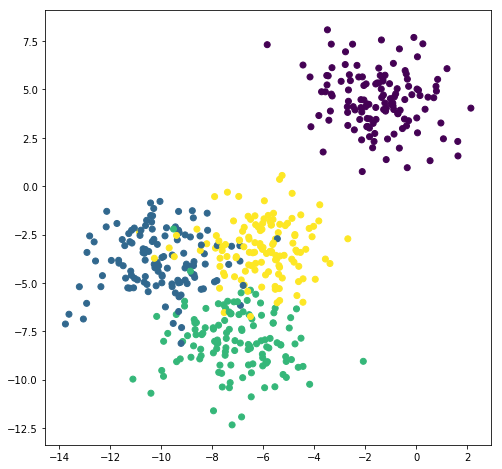

In [3]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
X1, y1 = make_blobs(n_samples=500,
                  n_features=2,
                  centers=4,
                  cluster_std=1.5,
                  center_box=(-10.0, 10.0),
                  shuffle=True,    # przetasowanie kolejności próbek
                  random_state=1)  # ustawienie momentu startu zmiennej pseudolosowej w celu zapewnienia powtarzalności wyników
columns = ['feature' + str(x) for x in np.arange(1, X1.shape[1]+1, 1)]
d = {key: values for key, values in zip(columns, X1.T)}
d['label'] = y1
dane1 = pd.DataFrame(d).reindex(columns=columns+['label'])

#Wyświelenie blobów
%matplotlib inline
import matplotlib.pyplot as plt
plt.figure(figsize=(8,8))
plt.scatter(dane1.feature1, dane1.feature2, marker='o', c=dane1.label)

### 2 Bagging

In [4]:
import numpy as np
import pandas as pd
from sklearn.datasets import make_blobs
X2, y2 = make_blobs(n_samples=1000,
                  n_features=4,
                  centers=4,
                  cluster_std=[5,4,3.5,5],
                  center_box=(-10.0, 10.0),
                  shuffle=True,    # przetasowanie kolejności próbek
                  random_state=1)  # ustawienie momentu startu zmiennej pseudolosowej w celu zapewnienia powtarzalności wyników
columns = ['feature' + str(x) for x in np.arange(1, X2.shape[1]+1, 1)]
d = {key: values for key, values in zip(columns, X2.T)}


d['label'] = y2
dane2 = pd.DataFrame(d).reindex(columns=columns+['label'])

#Wyciągnięcie nazw kolumn ze zmiennymi objaśniającymi (cechami) 
cechy = dane2.columns.values
cechy = np.delete(cechy,-1)

from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(dane2[cechy], dane2['label'], test_size=0.2, random_state=1)



In [5]:
from sklearn.ensemble import BaggingClassifier
from sklearn.neighbors import KNeighborsClassifier
bagging = BaggingClassifier(KNeighborsClassifier(),
                            max_samples=0.5, max_features=0.5)

bagging.fit(X2_train,y2_train)

BaggingClassifier(base_estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform'),
         bootstrap=True, bootstrap_features=False, max_features=0.5,
         max_samples=0.5, n_estimators=10, n_jobs=1, oob_score=False,
         random_state=None, verbose=0, warm_start=False)

In [6]:
# Dokonanie predykcji dla zbioru X_test:
bagging_prediction = bagging.predict(X2_test) 
# Wyświetlenie raportu klasyfikacji oraz macierzy pewności:
from sklearn import metrics
print "Błąd klasyfikacji:", 1-bagging.score(X2_test,y2_test)
print("Raport klasyfikacji: ")
print(metrics.classification_report(y2_test, bagging_prediction))
print("Macierz pewnosci: ")
print(metrics.confusion_matrix(y2_test, bagging_prediction))

Błąd klasyfikacji: 0.21
Raport klasyfikacji: 
             precision    recall  f1-score   support

          0       0.72      0.71      0.72        55
          1       0.84      0.88      0.86        41
          2       0.87      0.94      0.90        50
          3       0.73      0.67      0.70        54

avg / total       0.79      0.79      0.79       200

Macierz pewnosci: 
[[39  3  2 11]
 [ 3 36  2  0]
 [ 0  1 47  2]
 [12  3  3 36]]


### 3 Boosting

In [7]:
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import AdaBoostClassifier

#Inicjalizacja modelu klasyfikatora Ada Boost
ada_boost_model = AdaBoostClassifier(n_estimators=100)
# Wyliczenie wartości błędu przy pomocy walidacji krzyżowej
scores = cross_val_score(ada_boost_model, dane2[cechy], dane2.label, cv=5)
print "Średnia wartość błędu: ", 1-scores.mean() 


Średnia wartość błędu:  0.302


In [8]:
# Uczenie modelu przy pomocy zbioru treningowego X2
ada_boost_model.fit(X2_train, y2_train)
ada_boost_model_prediction = ada_boost_model.predict(X2_test)
print "Błąd klasyfikacji:", 1-ada_boost_model.score(X2_test,y2_test)
print("Raport klasyfikacji: ")
print(metrics.classification_report(y2_test, ada_boost_model_prediction))
print("Macierz pewnosci: ")
print(metrics.confusion_matrix(y2_test, ada_boost_model_prediction))

Błąd klasyfikacji: 0.4
Raport klasyfikacji: 
             precision    recall  f1-score   support

          0       0.55      0.69      0.61        55
          1       0.71      0.59      0.64        41
          2       0.83      0.30      0.44        50
          3       0.54      0.80      0.65        54

avg / total       0.65      0.60      0.58       200

Macierz pewnosci: 
[[38  3  0 14]
 [13 24  3  1]
 [11  3 15 21]
 [ 7  4  0 43]]


### 3 Voting
Do opracowania ensembla posłużymy się trzema klasyfikatorami:
1. Liniowym SVM-em
2. Drzewem decyzyjnym o głębokości 2
3. Naiwnym Bayesem
Nasz klasyfikator będzie klasyfikatorem głosującym z opcją 'hard'. Wybrana zostania klasa która będzie miała przewagę głosów.

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import VotingClassifier

# Inicjalizacja 3 klasyfikatorów
clf1 = svm.LinearSVC(C=1)
clf2 = DecisionTreeClassifier(max_depth=2,random_state=1)
clf3 = GaussianNB()
#Inicjalizacja klasyfikatora głosującego (z opcją hard)
eclf = VotingClassifier(estimators=[('svm', clf1), ('dt', clf2), ('gnb', clf3)], voting='hard')

# Walidacja krzyżowa
for clf, label in zip([clf1, clf2, clf3, eclf], ['Linear SVM', 'Drzewo Decyzyjne', 'Naiwny Bayes', 'Ensemble']):
    scores = cross_val_score(clf, dane2[cechy], dane2['label'], cv=5, scoring='accuracy')
    print("Skuteczność: %0.2f (+/- %0.2f) [%s]" % (scores.mean(), scores.std(), label))

Skuteczność: 0.81 (+/- 0.03) [Linear SVM]
Skuteczność: 0.60 (+/- 0.04) [Drzewo Decyzyjne]
Skuteczność: 0.82 (+/- 0.02) [Naiwny Bayes]
Skuteczność: 0.81 (+/- 0.02) [Ensemble]


Drugą opcją jest klasyfikator głosujący z opcją 'soft'. Opcją tą możemy użyć tylko dla klasyfikatorów które są w stanie polczyć prawdopodobieństwo przynależności do danej klasy. Następnie klasyfikator głosujący określa przynależną klasę biorąc pod uwagę poszczególne prawdopodobieństwa. Opcjonalnie można dołożyć wagi, które same będą wzmacniać wyniki otrzymane przez dane klasyfikatory.

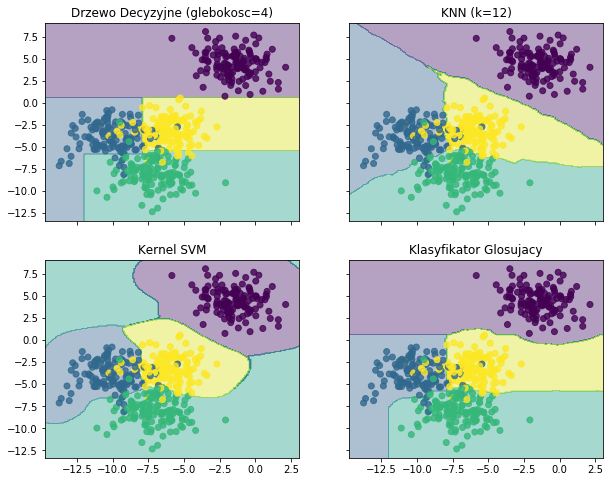

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier
from itertools import product

# Inicjalizacja klasyfikatorów
clf1 = DecisionTreeClassifier(max_depth=4)
clf2 = KNeighborsClassifier(n_neighbors=12)
clf3 = SVC(kernel='rbf', probability=True)
eclf = VotingClassifier(estimators=[('dt', clf1), ('knn', clf2), ('svc', clf3)], voting='soft', weights=[2,1,2])

clf1 = clf1.fit(X1,y1)
clf2 = clf2.fit(X1,y1)
clf3 = clf3.fit(X1,y1)
eclf = eclf.fit(X1,y1)

# Wyrysowanie obszarow decyzyjnych
x_min, x_max = X1[:, 0].min() - 1, X1[:, 0].max() + 1
y_min, y_max = X1[:, 1].min() - 1, X1[:, 1].max() + 1
xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1),
                     np.arange(y_min, y_max, 0.1))

f, axarr = plt.subplots(2, 2, sharex='col', sharey='row', figsize=(10, 8))

for idx, clf, tt in zip(product([0, 1], [0, 1]),
                        [clf1, clf2, clf3, eclf],
                        ['Drzewo Decyzyjne (glebokosc=4)', 'KNN (k=12)',
                         'Kernel SVM', 'Klasyfikator Glosujacy']):

    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)

    axarr[idx[0], idx[1]].contourf(xx, yy, Z, alpha=0.4)
    axarr[idx[0], idx[1]].scatter(dane1.iloc[:, 0], dane1.iloc[:, 1], c=dane1['label'], alpha=0.8)
    axarr[idx[0], idx[1]].set_title(tt)

plt.show()